# Homework 3
## Exercise 5 - Challenge
Pierluigi Compagnone

In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
import networkx as nx 
from utility import *
from itertools import product

### Try to also find a better algorithm to estimate the parameters. 
### (Tabu search)

In [9]:
def PAM_graph(k, agents):
    
    # Starting point Graph 
    np.random.seed(0)
    G = nx.generators.classic.complete_graph(k + 1)

    # Preferential attachement
    for nt in range(k+1, agents):
        w = np.array(G.degree)[:,1]
        prob = w / np.sum(w) 
        c = (k + (nt % 2)) // 2

        idx = np.random.choice(G.nodes(), size =c, replace=False, p =prob)
        G.add_node(nt)

        for link in range(c):
            G.add_edge( nt, idx[link]) 
            
    return G

In [10]:
def pandemic_simulation(G, beta, ro, initial_infected, pandemic_par ):
    
    # Pandemic simulation parameters
    vax =  pandemic_par["vax"]
    n_steps = pandemic_par["n_steps"]
    n_weeks = pandemic_par["n_weeks"]
    n_stati = pandemic_par["n_stati"]
    poli = pandemic_par["poli"]
    n_nodes = len(G)
    
    simu= np.zeros([n_steps,n_weeks, n_nodes])
    
    # Simulation loop
    for _ in range(0,n_steps):
        states = np.zeros([n_weeks, n_nodes])
                          
        # Initial condition 
        x0 = set_init_config(G, initial_infected, poli)
        vax_state = vaccination(vax[0], np.copy(x0), n_nodes)
        states[0] = vax_state
                          
        # Single simulation loop
        for i in range(1,n_weeks):         
            perc = vax[i] - vax[i-1]
            vax_state = vaccination(perc, np.copy(states[i-1]), n_nodes)
                                    
            # Take last configuration
            x = np.copy( vax_state )
            rates = new_conf_rates(G, x, beta, ro, n_stati )
                          
            # Chose the next configuration 
            next_pos = np.argmax(np.cumsum(rates,axis=1) > np.random.rand(n_nodes,1), axis=1)
            states[i] = next_pos
                                   
        simu[_] = states
        
    return simu               

In [11]:
def generate_neighbors(temp_sol):
    
    # Neighborhood generation
    k = temp_sol[0]
    k_n = [  k-1, k-2, k, k+1, k+2]
    
    beta = temp_sol[1]
    beta_n = [  np.round(beta,3),
                np.round(beta-0.01,3), np.round(beta+ 0.01,3),
                np.round(beta-0.05,3), np.round(beta+ 0.05,3),
                np.round(beta-0.1, 3),  np.round(beta+ 0.1, 3),
             ]
    
    ro = temp_sol[2]
    ro_n = [   np.round(ro,3), 
               np.round(ro-0.01,3), np.round(ro+ 0.01,3),
               np.round(ro-0.05,3), np.round(ro+ 0.05,3),
               np.round(ro-0.1, 3),  np.round(ro+ 0.1, 3)
           ]
    
    cmb = list(product(k_n, beta_n, ro_n))   
    cmb.remove((k, np.round(beta,3), np.round(ro,3)))
    
    return cmb

In [12]:
def neigh_evaluation(cmb,  pandemic_par, I0, n_nodes, Graph_type): 
    
    # Take all the nieghbors and computer the RMSE
    results = []
    
    for combination in cmb:
        
        if combination[0]<= 1 : 
            continue

        if combination[1] <= 0 or combination[1] >= 1 :
            continue
            
        if combination[2] <= 0 or combination[2] >= 1 :
            continue
            
        # Graph Generation
        if Graph_type == "PAM":
            G = PAM_graph(combination[0], n_nodes )
        elif Graph_type == "SW" :
            G = nx.newman_watts_strogatz_graph(n_nodes, combination[0], p=0.5, seed=100)
        
        # Pandemic simulation
        simulation = pandemic_simulation(G, combination[1], combination[2], I0[0],  pandemic_par )
        
        # Compute the average number of newly infected individuals each week
        all_I = np.zeros([simulation.shape[0], simulation.shape[1]])

        for i in range( simulation.shape[0] ):     
            all_I[i] =  new_weekly( simulation[i], 1 ) 

        I = np.mean(all_I ,axis=0)
        
        # Compute RMSE 
        RMSE = np.sqrt( (np.sum(  (I[1:]-I0[1:])**2) ) / 15 )
        results.append(RMSE)
        
        #print("[k:{}, beta:{}, ro:{}] --> RMSE:{}".format(combination[0], combination[1], combination[2],RMSE))
    
    # Chose the parameters that minimize the RMSE
    results = np.array(results)
    best_index = np.argmin(results)
    best_par = cmb[best_index]
    sorted_index = np.argsort(results)
    
    return [best_par[0], best_par[1], best_par[2]], results[best_index], sorted_index

In [13]:
# Pandemic parameters initialization 
pandemic_par = {
    "vax" : [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60],
    "n_steps" : 10,
    "n_weeks" : 15+1,
    "n_stati" : 4,
    "poli" : "random"
}

# Starting point for parameters to optimize
n_nodes = 934
I0 = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
k, beta, ro = 10, 0.3, 0.6

In [ ]:
# TABOO SEARCH
# Evalute the initial solution 
temp_sol, temp_rmse, _ = neigh_evaluation([[k, beta, ro]],  pandemic_par, I0, n_nodes, "PAM")
best_sol, best_rmse = temp_sol, temp_rmse
tabu_list = []

n_iter = 0
print("START")

# Iterate over a certain number of iterations
while n_iter < 15:
    
    print("iteration:",n_iter)
    
    # If the taboo list legth is equal to the maximum one remove the first element
    if len(tabu_list) == 50 :
        tabu_list.pop(0)
    
    # Generate the neighborhood
    list_neigh = generate_neighbors(temp_sol)
    
    # Evalute the neighborhood and get the best one with a list of indexes sorted by the RMSE
    temp_sol, temp_rmse, sorted_index = neigh_evaluation(list_neigh,  pandemic_par, I0, n_nodes, "PAM")
    
    # If a better solution is found update
    if temp_rmse < best_rmse: 
        best_sol, best_rmse = temp_sol, temp_rmse 
        print("\nNew BEST {} --> RMSE: {}]\n".format(best_sol, best_rmse))
    
    # if no better solution is found prepare a taboo move
    else :
        
        # take a new solution if is note in taboo list 
        for i_s in sorted_index:
            temp_sol = list_neigh[i_s]
            
            if temp_sol not in tabu_list:
                break
                
        # update the taboo list
        print("Tabu move")
        tabu_list.append(temp_sol)
        print("\n[k:{}, beta:{}, ro:{}] TABU\n".format(temp_sol[0], temp_sol[1], temp_sol[2]))
        
    n_iter += 1
        
print("END")
print("Best Parameters: {} --> RMSE: {}".format(best_sol, best_rmse))

### Algorithm results 

START
iteration: 0

New BEST [9, 0.2, 0.55] --> RMSE: 4.89652938314476]

iteration: 1

New BEST [9, 0.21, 0.55] --> RMSE: 3.9116066605253996]

iteration: 2
Tabu move

[k:9, beta:0.21, ro:0.54] TABU

iteration: 3
Tabu move

[k:9, beta:0.21, ro:0.55] TABU

iteration: 4
Tabu move

[k:9, beta:0.22, ro:0.55] TABU

iteration: 5
Tabu move

[k:9, beta:0.22, ro:0.54] TABU

iteration: 6
Tabu move

[k:9, beta:0.21, ro:0.53] TABU

iteration: 7
Tabu move

[k:9, beta:0.21, ro:0.52] TABU

iteration: 8
Tabu move

[k:9, beta:0.21, ro:0.51] TABU

iteration: 9
Tabu move

[k:9, beta:0.21, ro:0.5] TABU

iteration: 10
Tabu move

[k:9, beta:0.21, ro:0.49] TABU

iteration: 11
Tabu move

[k:9, beta:0.22, ro:0.59] TABU

iteration: 12
Tabu move

[k:9, beta:0.22, ro:0.64] TABU

iteration: 13
Tabu move

[k:9, beta:0.21, ro:0.63] TABU

iteration: 14
Tabu move

[k:9, beta:0.21, ro:0.62] TABU

iteration: 15
Tabu move

[k:9, beta:0.22, ro:0.63] TABU

In [18]:
# Best model simulation
# Initialization
best_par = [9, 0.21, 0.55]
print("Best founded parameters:", best_par)

# Make more steps in the simulation to have a less biased result
pandemic_par["n_steps"] = 100

# Random Graph with PA initialization 
G = PAM_graph(best_par[0], n_nodes )

# Simulation loop
simu = pandemic_simulation(G, best_par[1], best_par[2], I0[0], pandemic_par )

Best founded parameters: [9, 0.21, 0.55]


Average new infected per week: [ 0.94  1.64  5.48 13.89 27.1  32.39 28.17 20.69 12.88  8.78  5.9   4.15
  2.7   1.73  1.1   0.76]


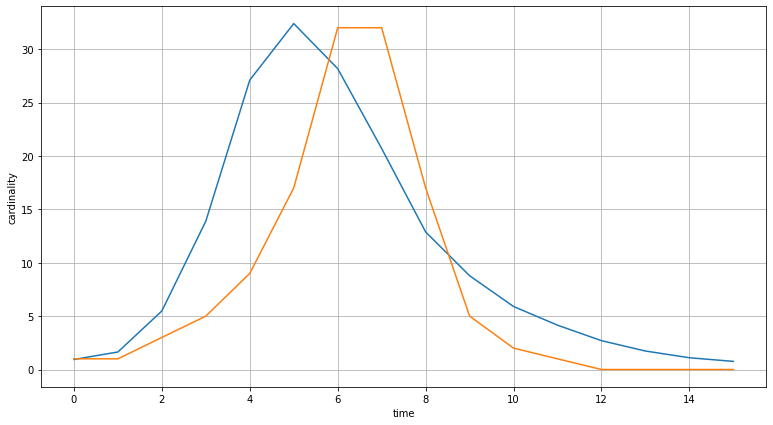

In [19]:
# Compute the average new infected
simu_week_i = np.zeros([pandemic_par["n_steps"], pandemic_par["n_weeks"]])

for i in range( simu.shape[0] ):     
    simu_week_i[i] =  new_weekly( simu[i], 1 ) 
    
avg_week_i = np.mean(simu_week_i ,axis=0)

print("Average new infected per week: {}".format(avg_week_i))

# Plot a comparison between  real and simulated new infected
plt.figure(figsize = (13 ,7))
plt.plot(range(pandemic_par["n_weeks"]), avg_week_i, label="Simulated")) 
plt.plot(range(pandemic_par["n_weeks"]), I0, label="Real") 
plt.xlabel("Week")
plt.ylabel("# of person")
plt.title("Average number of real and simulated new infected ")
plt.grid()
plt.legend()
#plt.savefig("./images/Ex5_0.png")
plt.show()

### Try to find a better random graph (i.e. one that does not use preferential attachment) to represent the network for the pandemic.
### (Small wolrd Graph)

In [20]:
# Pandemic parameters initialization 
pandemic_par = {
    "vax" : [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60],
    "n_steps" : 10,
    "n_weeks" : 15+1,
    "n_stati" : 4,
    "poli" : "random"
}

# Starting point for parameters to optimize
n_nodes = 934
I0 = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
k, beta, ro = 10, 0.3, 0.6

In [ ]:
# TABOO SEARCH
temp_sol, temp_rmse, _ = neigh_evaluation([[k, beta, ro]],  pandemic_par, I0, n_nodes, "SW")
best_sol, best_rmse = temp_sol, temp_rmse
tabu_list = []

n_iter = 0
print("START")

while n_iter < 15:
    
    print("iteration:",n_iter)
    
    if len(tabu_list) == 25 :
        tabu_list.pop(0)
    
    list_neigh = generate_neighbors(temp_sol)
    temp_sol, temp_rmse, sorted_index = neigh_evaluation(list_neigh,  pandemic_par, I0, n_nodes, "SW")
    
    
    if temp_rmse < best_rmse: 
        best_sol, best_rmse = temp_sol, temp_rmse 
        print("\nNew BEST {} --> RMSE: {}]\n".format(best_sol, best_rmse))
        
    else :
        print("Tabu move")
        tabu_list.append(temp_sol)
        print("\n[k:{}, beta:{}, ro:{}] TABU\n".format(temp_sol[0], temp_sol[1], temp_sol[2]))
        
        for i_s in sorted_index:
            temp_sol = list_neigh[i_s]
            
            if temp_sol not in tabu_list:
                break
    
    n_iter += 1
        
print("END")
print("Best Parameters: {} --> RMSE: {}".format(best_sol, best_rmse))

### Algorithm Results

START
iteration: 0

New BEST [10, 0.2, 0.7] --> RMSE: 7.6997835467412115]

iteration: 1

New BEST [12, 0.15, 0.75] --> RMSE: 5.967243919934897]

iteration: 2

New BEST [14, 0.14, 0.8] --> RMSE: 5.79436507882155]

iteration: 3

New BEST [12, 0.19, 0.81] --> RMSE: 5.66809785848245]

iteration: 4

New BEST [12, 0.19, 0.86] --> RMSE: 4.621471627090228]

iteration: 5
Tabu move

[k:14, beta:0.14, ro:0.87] TABU

iteration: 6
Tabu move

[k:16, beta:0.14, ro:0.97] TABU

iteration: 7
Tabu move

[k:15, beta:0.04, ro:0.96] TABU

iteration: 8
Tabu move

[k:13, beta:0.05, ro:1.06] TABU

iteration: 9
Tabu move

[k:12, beta:0.06, ro:0.96] TABU

iteration: 10
Tabu move

[k:12, beta:0.16, ro:0.86] TABU

iteration: 11
Tabu move

[k:11, beta:0.21, ro:0.96] TABU

iteration: 12
Tabu move

[k:11, beta:0.2, ro:1.06] TABU

iteration: 13
Tabu move

[k:10, beta:0.21, ro:1.07] TABU

iteration: 14
Tabu move

[k:9, beta:0.22, ro:1.08] TABU

iteration: 15
Tabu move

[k:8, beta:0.22, ro:1.13] TABU

In [24]:
# Initialization
best_par= [12, 0.19, 0.86]
print("Best founded parameters:", best_par)

# Make more steps in the simulation to have a less biased result
pandemic_par["n_steps"] = 100

# Small World Graph initialization 
G = nx.newman_watts_strogatz_graph(n_nodes, best_par[0], p=0.5, seed = 100)

# Simulation loop
simu = pandemic_simulation(G, best_par[1], best_par[2], I0[0], pandemic_par )

Best founded parameters: [12, 0.19, 0.86]


Average new infected per week: [ 0.97  2.95  6.74 13.26 23.61 33.3  38.37 33.53 25.67 18.91 13.92 10.48
  7.64  5.66  3.99  3.27]


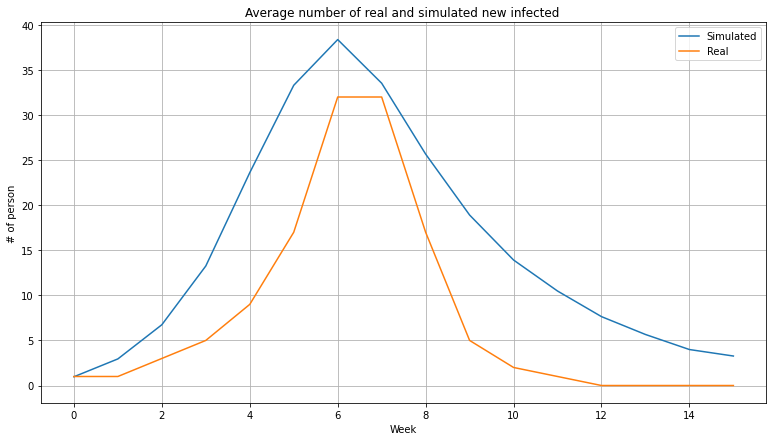

In [25]:
simu_week_i = np.zeros([pandemic_par["n_steps"], pandemic_par["n_weeks"]])

for i in range( simu.shape[0] ):     
    simu_week_i[i] =  new_weekly( simu[i], 1 ) 
    
avg_week_i = np.mean(simu_week_i ,axis=0)

print("Average new infected per week: {}".format(avg_week_i))

plt.figure(figsize = (13 ,7))
plt.plot(range(pandemic_par["n_weeks"]), avg_week_i, label="Simulated") 
plt.plot(range(pandemic_par["n_weeks"]), I0, label = "Real") 
plt.xlabel("Week")
plt.ylabel("# of person")
plt.title("Average number of real and simulated new infected ")
plt.legend()
plt.grid()
#plt.savefig("./images/Ex5_1.png")
plt.show()